In [11]:
!pip install pandas-datareader

     |████████████████████████████████| 122kB 332kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# Import Librairies

import pandas as pd
import datetime

import pandas_datareader.data as web
from pandas import Series, DataFrame

In [13]:
# Create a start and end date

start = datetime.datetime(2010, 1, 1)

end = datetime.datetime.now()

### Loading Yahoo Finance Dataset

In [15]:
# Create a DataFrame

data = web.DataReader('AAPL', 'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.681330
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.727465
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.302330
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.253704
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.428249


### Exploring the Data

In [16]:
# Get the closing price

close_px = data['Adj Close']

# Rolling the closing price

mavg = close_px.rolling(window = 100).mean()

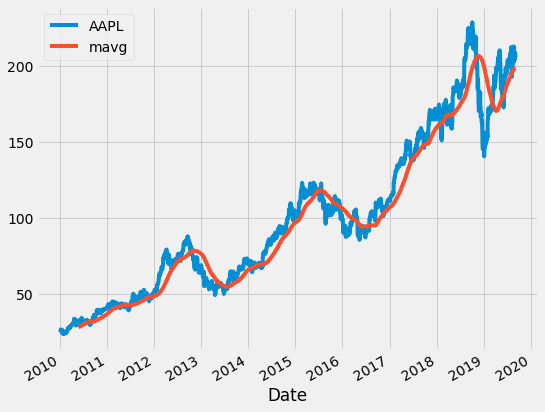

In [19]:
# Importing Matplotlib

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style

# Adjusting the size of Matplotlib
mpl.rc('figure', figsize = (8,7))

# Adjusting the style of Matplotlib
style.use('fivethirtyeight')

# Plotting using Matplotlib
close_px.plot(label = 'AAPL')
mavg.plot(label = 'mavg')
plt.legend()

In [20]:
# Getting return as close_px / close_px.shift(1) - 1

# returndev = close_px / close_px.shift(1) -1

rets = close_px.pct_change()

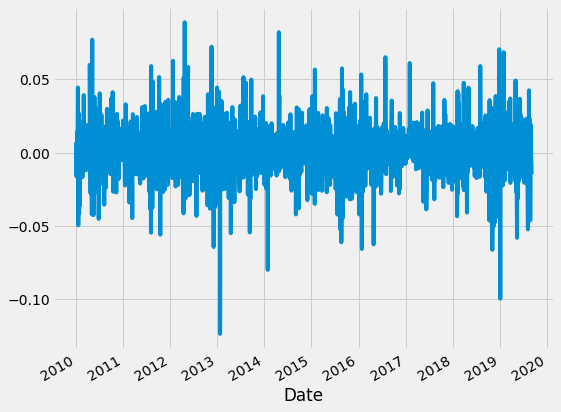

In [21]:
# Plot and label it as return

rets.plot(label = 'return')

### Predicting Stocks Price

In [22]:
dfreg = data.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (data['High'] - data['Low']) / data['Close'] * 100.0
dfreg['PCT_change'] = (data['Close'] - data['Open']) / data['Open'] * 100.0

In [47]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


### Pre-processing & Cross Validation

In [23]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X', X.shape)
print('Dimension of y', y.shape)

Dimension of X (2408, 4)
Dimension of y (2408,)


In [24]:
# Separation of training and testing of model by cross validation train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

### Buil the Model

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Simple Linear Analysis & Quadratic Discriminant Analysis

In [39]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression
clfpoly = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors = 2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

### Test the Model

In [38]:
# Assess the Model using confidence

confreg = clfreg.score(X_test, y_test)
confpoly = clfpoly.score(X_test, y_test)
confknn = clfknn.score(X_test, y_test)


print('The regression confidence is', confreg)
print('The quadratic regresssion confidence is', confpoly)
print('The knn regresssion confidence is', confknn)

The regression confidence is 0.9680712201392753
The quadratic regresssion confidence is 0.9709260091859708
The knn regresssion confidence is 0.9463967798778082


# The quadratic regresssion has the best perfomence

In [29]:
# printing the forecast

forecast_set = clfreg.predict(X_lately)

# Create an empty column for the forecast result

print(forecast_set)
dfreg['Forecast'] = np.nan

[207.40382843 210.66547226 206.84011892 202.69817902 192.09808733
 196.10357918 198.28452003 202.6155673  201.01813655 200.57498931
 208.49188782 202.31975924 201.76548874 206.23679079 210.00329007
 209.94440755 212.27294355 212.1703104  202.2587895  206.19529103
 204.10063857 205.64735908 208.83486712 208.58995671 205.67277411]


In [30]:
# Create a time log for the prediction by getting the last date

last_date = dfreg.iloc[-1].name

last_unix = last_date

next_unix = last_unix + datetime.timedelta(days=1)

# Populating forecast result
for i in forecast_set:
  next_date = next_unix
  next_unix += datetime.timedelta(days=1)
  dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

### Plotting the prediction

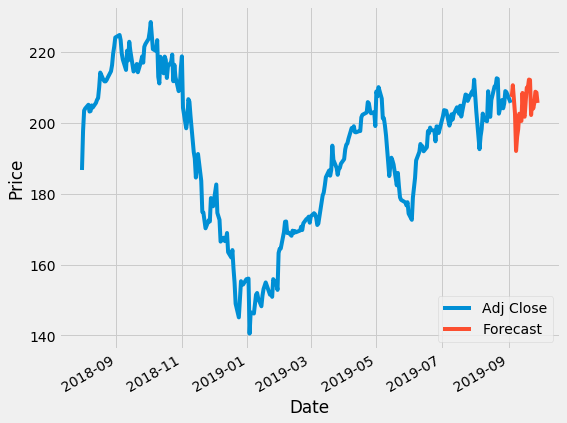

In [31]:
# plotting dfreg Adj Close & Forecast

dfreg['Adj Close'].tail(300).plot()
dfreg['Forecast'].tail(300).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()